# Final Project
## ExGender Bias 
__Lucas Calero Forero, Rebecca McBrayer__

In [2]:
import os
import string
import re

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
english_corpus = []
spanish_corpus = []
french_corpus = []
german_corpus = []

for filename in os.listdir('dev'):
    if '.en.' in filename:
        with open(f'dev/{filename}') as f:
            english_corpus.extend(f.readlines())
    if '.es.' in filename:
        with open(f'dev/{filename}') as f:
            spanish_corpus.extend(f.readlines())
    if '.fr.' in filename:
        with open(f'dev/{filename}') as f:
            french_corpus.extend(f.readlines())
    if '.de.' in filename:
        with open(f'dev/{filename}') as f:
            german_corpus.extend(f.readlines())

In [4]:
def preprocess(corpus):
    useful = []
    for item in corpus:
        if len(item)> 4 and '<seg' in item:
            start = item.find('">')
            end = item.find('</')
            useful.append(item[start+3:end].lower())

    # Remove punctuation
    exclude = set(string.punctuation)
    nopun = []
    for st in useful:
        st = ''.join(ch for ch in st if ch not in exclude)
        nopun.append(st)

    # Add start and ending tokens, and make all words lowercase
    data = [sentence.split() for sentence in nopun]
    data = list(filter(lambda a: len(a)>2, data))  # Remove blank sentences
    return data

In [5]:
english_data = preprocess(english_corpus)
spanish_data = preprocess(spanish_corpus)
french_data = preprocess(french_corpus)
german_data = preprocess(german_corpus)

In [6]:
def remove_articles(data, articles):
    clean_data = []
    for st in data:
        st = [word for word in st if not word in articles]
        clean_data.append(st)
    return clean_data

english_articles = ['the', 'a']
spanish_articles = ['el', 'uno', 'la', 'un', 'una', 'los', 'las', 'unos', 'unas']
french_articles = ['le', 'la', 'les', 'une', 'un']
german_articles = ['der', 'die', 'das', 'dem', 'den', 'ein', 'eine', 'einer', 'einem', 'einen', 'des']

english_no = remove_articles(english_data, english_articles)
spanish_no = remove_articles(spanish_data, spanish_articles)
french_no = remove_articles(french_data, french_articles)
german_no = remove_articles(german_data, german_articles)

In [7]:
# Train embeddings on the full corpuses

english_model = Word2Vec(sentences=english_data, size=200, window=7, min_count=2, workers=4, sg=1)
spanish_model = Word2Vec(sentences=spanish_data, size=200, window=7, min_count=2, workers=4, sg=1)
french_model = Word2Vec(sentences=french_data, size=200, window=7, min_count=2, workers=4, sg=1)
german_model = Word2Vec(sentences=german_data, size=200, window=7, min_count=2, workers=4, sg=1)

print(f'English vocab size: {len(english_model.wv.vocab)}')
print(f'Spanish vocab size: {len(spanish_model.wv.vocab)}')
print(f'French vocab size: {len(french_model.wv.vocab)}')
print(f'German vocab size: {len(german_model.wv.vocab)}')

English vocab size: 17439
Spanish vocab size: 21096
French vocab size: 22095
German vocab size: 26759


In [57]:
# Train embeddings on the full corpuses with CBOW instead of skip-gram

english_cbow = Word2Vec(sentences=english_data, size=200, window=7, min_count=2, workers=4)
spanish_cbow = Word2Vec(sentences=spanish_data, size=200, window=7, min_count=2, workers=4)
french_cbow = Word2Vec(sentences=french_data, size=200, window=7, min_count=2, workers=4)
german_cbow = Word2Vec(sentences=german_data, size=200, window=7, min_count=2, workers=4)

print(f'English vocab size: {len(english_model.wv.vocab)}')
print(f'Spanish vocab size: {len(spanish_model.wv.vocab)}')
print(f'French vocab size: {len(french_model.wv.vocab)}')
print(f'German vocab size: {len(german_model.wv.vocab)}')

English vocab size: 17439
Spanish vocab size: 21096
French vocab size: 22095
German vocab size: 26759


In [8]:
# Train embeddings on the corpuses without any articles

english_model_no = Word2Vec(sentences=english_no, size=200, window=7, min_count=2, workers=4, sg=1)
spanish_model_no = Word2Vec(sentences=spanish_no, size=200, window=7, min_count=2, workers=4, sg=1)
french_model_no = Word2Vec(sentences=french_no, size=200, window=7, min_count=2, workers=4, sg=1)
german_model_no = Word2Vec(sentences=german_no, size=200, window=7, min_count=2, workers=4, sg=1)

print(f'English no article vocab size: {len(english_model_no.wv.vocab)}')
print(f'Spanish no article vocab size: {len(spanish_model_no.wv.vocab)}')
print(f'French no article vocab size: {len(french_model_no.wv.vocab)}')
print(f'German no article vocab size: {len(german_model_no.wv.vocab)}')

English no article vocab size: 17437
Spanish no article vocab size: 21087
French no article vocab size: 22090
German no article vocab size: 26748


In [9]:
english_words = ['President', 'Governor', 'Militant', 'Slow', 'Dress', 'Actress', 'Actor', 'Game', 'Player', 'Roses', 'women', 'men', 'Mother', 'Father', 'Voters', 'User', 'Ambition', 'Vulnerable', 'Boss', 'Busy', 'Cousin', 'Police', 'Model', 'Professor']
spanish_words = ['Presidenta', 'Presidente', 'Gobernador', 'Militante', 'Lenta', 'Lento', 'vestido', 'actriz', 'actor', 'Juego', 'Jugador', 'Rosas', 'señora', 'señor', 'Madre', 'Padre', 'votantes', 'Usuario', 'Ambición', 'vulnerable', 'Jefe', 'ocupada', 'ocupado', 'primo', 'prima', 'modelo', 'profesor', 'profesora']
french_words = ['Président', 'Présidente', 'Gouverneur', 'Militant', 'lente', 'robe', 'actrice', 'acteur', 'Jeu', 'Jouer', 'Roses', 'Femmes', 'Hommes', 'Mère', 'Père', 'électeurs', 'utilisateur', 'Ambition', 'vulnérable', 'patron', 'patronne', 'occupé', 'occupée', 'Cousine', 'police', 'modèle', 'professeur']
german_words = ['Präsident', 'Präsidentin', 'Gouverneur', 'Millitante', 'langsam', 'Kleid', 'Schauspielerin', 'Schauspieler', 'Spiel', 'Spieler', 'Frauen', 'Männer', 'Mutter', 'Vater', 'Wähler', 'Benutzer', 'Chef', 'Chefin',  'Polizei', 'Model', 'Professor', 'Professorin']

Removed words: Spanish - Gobernadora, jugadora, policia

               French - Gouverneure, lent, jouereuse, utilisatrice, cousin

               German - Gouverneurin, spielerin, Rosen, ehrgeiz, verletzlich, beschäftig, cousin, cousine, 

In [150]:
english_gender_pairs = [['man', 'woman'], ['he', 'she'], ['actor', 'actress'], ['father', 'mother']]
spanish_gender_pairs = [['señor', 'señora'], ['el', 'ella'], ['actor', 'actriz'], ['padre', 'madre']]
french_gender_pairs = [['homme', 'femme'], ['il', 'elle'], ['acteur', 'actrice'], ['père', 'mère']]
german_gender_pairs = [['mann', 'frau'], ['er', 'sie'], ['schauspieler', 'schauspielerin'], ['vater', 'mutter']]

def get_normalized_differences(model, pairs):
    differences = []
    for pair in pairs:
        norm_0 = model.wv[pair[0]]/np.linalg.norm(model.wv[pair[0]])
        norm_1 = model.wv[pair[1]]/np.linalg.norm(model.wv[pair[1]])
        differences.append(norm_0-norm_1)
    return differences

english_differences = get_normalized_differences(english_model, english_gender_pairs)
spanish_differences = get_normalized_differences(spanish_model, spanish_gender_pairs)
french_differences = get_normalized_differences(french_model, french_gender_pairs)
german_differences = get_normalized_differences(german_model, german_gender_pairs)

In [151]:
def get_gender_dimension(differences, visualize=True):
    pca = PCA()
    pca.fit(differences)
    
    if visualize:
        plt.bar(np.arange(4), pca.explained_variance_ratio_)
        plt.show()
    
    return pca.components_[0]

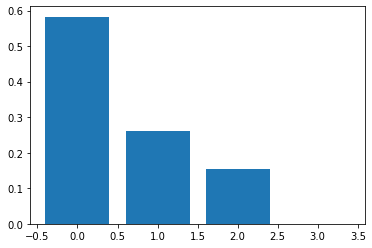

In [168]:
english_gd = get_gender_dimension(english_differences)

In [169]:
english_model.wv.similar_by_vector(english_gd)

[('700', 0.5352970957756042),
 ('billion', 0.5204228758811951),
 ('2008', 0.5173379778862),
 ('dollars', 0.49832683801651),
 ('crowns', 0.484467476606369),
 ('17', 0.461530864238739),
 ('2009', 0.4604175388813019),
 ('october', 0.45628032088279724),
 ('december', 0.45036524534225464),
 ('shares', 0.4490417242050171)]

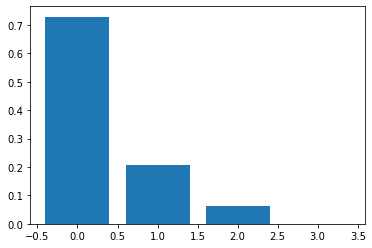

In [170]:
spanish_gd = get_gender_dimension(spanish_differences)

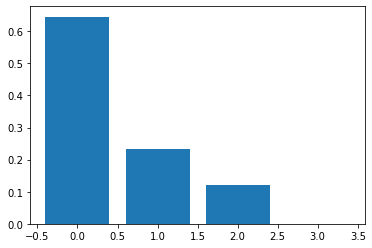

In [155]:
french_gd = get_gender_dimension(french_differences)

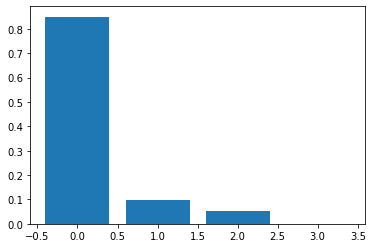

In [156]:
german_gd = get_gender_dimension(german_differences)

In [157]:
english_embeddings = [english_model.wv[word.lower()] for word in english_words]
spanish_embeddings = [spanish_model.wv[word.lower()] for word in spanish_words]
french_embeddings = [french_model.wv[word.lower()] for word in french_words]
german_embeddings = [german_model.wv[word.lower()] for word in german_words]

In [158]:
# Dictionary of words to normalized word embeddings
english_embed_dict = {word.lower(): english_model.wv[word.lower()]/np.linalg.norm(english_model.wv[word.lower()]) for word in english_words}
spanish_embed_dict = {word.lower(): spanish_model.wv[word.lower()]/np.linalg.norm(spanish_model.wv[word.lower()]) for word in spanish_words}
french_embed_dict = {word.lower(): french_model.wv[word.lower()]/np.linalg.norm(french_model.wv[word.lower()]) for word in french_words}
german_embed_dict = {word.lower(): german_model.wv[word.lower()]/np.linalg.norm(german_model.wv[word.lower()]) for word in german_words}

In [159]:
def gender_component(w, v, g):
    w_g = np.dot(w, g)*g
    w_perp = w-w_g
    w_perp_norm = np.linalg.norm(w_perp)
    
    v_g = np.dot(v, g)*g
    v_perp = v-v_g
    v_perp_norm = np.linalg.norm(v_perp)
    
    w_dot_v = np.dot(w, v)
    
    beta = (w_dot_v - np.dot(w_perp, v_perp)/(w_perp_norm*v_perp_norm))/w_dot_v
    return beta

In [171]:
gender_component(english_embed_dict['men'], english_embed_dict['women'], english_gd)

-0.002787693367613415

In [172]:
for word, embedding in english_embed_dict.items():
    for word2, embedding2 in english_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, english_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

president governor -0.02
president militant -0.01
president slow 0.01
president dress -0.12
president actress -0.01
president actor -0.09
president game 0.01
president player -0.1
president men -0.04
president mother -0.13
president father -0.06
president user -0.03
president ambition -0.03
president vulnerable -0.02
president boss -0.03
president busy -0.01
president cousin -0.03
president police 0.01
president model 0.02
president professor -0.04
governor president -0.02
governor slow -0.01
governor dress -0.02
governor actor -0.02
governor game -0.01
governor mother -0.02
governor police -0.02
governor model -0.01
militant president -0.01
militant dress -0.03
militant actor -0.03
militant player -0.01
militant mother -0.03
militant father -0.01
militant police -0.01
slow president 0.01
slow governor -0.01
slow dress -0.06
slow actor -0.05
slow player -0.03
slow men -0.01
slow mother -0.06
slow father -0.03
slow user -0.01
slow ambition -0.01
slow vulnerable -0.01
slow boss -0.01
slo

In [174]:
for word, embedding in spanish_embed_dict.items():
    for word2, embedding2 in spanish_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, spanish_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

presidenta jugador -0.1
presidenta señor -0.1
presidenta madre -0.1
presidenta votantes -0.1
presidenta modelo -0.1
presidente gobernador -0.1
presidente lenta -0.1
presidente lento -0.1
presidente vestido -0.2
presidente actriz -0.1
presidente actor -0.1
presidente juego -0.2
presidente jugador -0.3
presidente rosas -0.1
presidente señora -0.2
presidente señor -0.3
presidente madre -0.3
presidente padre -0.1
presidente votantes -0.3
presidente usuario -0.2
presidente ambición -0.1
presidente vulnerable -0.1
presidente ocupada -0.1
presidente ocupado -0.1
presidente primo -0.1
presidente prima -0.2
presidente modelo -0.3
presidente profesor -0.1
presidente profesora -0.1
gobernador presidente -0.1
gobernador señor -0.1
militante señor -0.1
militante votantes -0.1
militante modelo -0.1
lenta presidente -0.1
lento presidente -0.1
lento jefe -0.1
vestido presidente -0.2
vestido jefe -0.1
actriz presidente -0.1
actor presidente -0.1
actor jefe -0.1
juego presidente -0.2
juego jefe -0.1
jug

In [175]:
for word, embedding in french_embed_dict.items():
    for word2, embedding2 in french_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, french_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

président militant 0.01
président lente 0.01
président robe 0.01
président actrice 0.01
président acteur 0.01
président jeu 0.02
président jouer 0.01
président roses 0.01
président femmes 0.01
président mère 0.01
président père 0.01
président utilisateur 0.01
président ambition 0.01
président patron 0.01
président patronne 0.01
président occupé 0.01
président occupée 0.01
président cousine 0.01
président police -0.02
président modèle 0.01
présidente jeu -0.01
présidente jouer -0.01
présidente père -0.01
présidente professeur -0.01
gouverneur jeu -0.01
gouverneur jouer -0.01
gouverneur père -0.01
gouverneur professeur -0.01
militant président 0.01
militant hommes -0.01
militant police -0.02
lente président 0.01
lente jeu -0.01
lente jouer -0.01
lente police -0.01
robe président 0.01
robe police -0.02
actrice président 0.01
actrice hommes -0.01
actrice police -0.02
acteur président 0.01
acteur hommes -0.01
acteur électeurs -0.01
acteur police -0.02
jeu président 0.02
jeu présidente -0.01

In [176]:
for word, embedding in german_embed_dict.items():
    for word2, embedding2 in german_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, german_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

präsident präsidentin -0.14
präsident gouverneur -0.1
präsident millitante -0.16
präsident langsam -0.13
präsident kleid -0.11
präsident schauspielerin -0.07
präsident schauspieler -0.05
präsident spiel -0.05
präsident spieler -0.12
präsident frauen -0.31
präsident männer -0.2
präsident mutter -0.16
präsident vater -0.06
präsident wähler -0.12
präsident benutzer -0.2
präsident chef -0.1
präsident chefin -0.14
präsident polizei -0.07
präsident model -0.15
präsident professor -0.08
präsident professorin -0.12
präsidentin präsident -0.14
präsidentin schauspielerin -0.01
präsidentin schauspieler -0.01
präsidentin spiel -0.01
präsidentin männer 0.01
präsidentin mutter 0.01
präsidentin vater -0.01
präsidentin polizei -0.01
präsidentin professor -0.01
gouverneur präsident -0.1
gouverneur schauspieler -0.01
gouverneur spiel -0.01
gouverneur frauen -0.02
gouverneur männer -0.01
gouverneur benutzer -0.01
millitante präsident -0.16
millitante schauspielerin -0.01
millitante schauspieler -0.02
mil

In [165]:
gender_diff = english_embed_dict['men']-english_embed_dict['women']

for word, embedding in english_embed_dict.items():
    for word2, embedding2 in english_embed_dict.items():
        if word != word2 and 'men' not in word and 'men' not in word2:
            norm = np.linalg.norm(embedding-embedding2)
            if norm < 1:
                print(word, word2, np.dot(gender_diff, embedding-embedding2))

president governor -0.0019425792
president militant -0.006145278
president slow 0.03657881
president dress 0.04175341
president actress 0.03923607
president actor -0.03137803
president game 0.13183418
president roses 0.04731539
president father 0.01987448
president voters 0.036900222
president ambition 0.0029110303
president boss -0.0021079471
president busy 0.052831825
president cousin 0.010584817
president police -0.11488187
president professor -0.0015583369
governor president 0.0019425792
governor militant -0.0042026965
governor slow 0.038521394
governor dress 0.043695994
governor actress 0.041178647
governor actor -0.02943545
governor game 0.13377675
governor player 0.0706764
governor roses 0.049257964
governor mother 0.039010264
governor father 0.021817062
governor voters 0.0388428
governor user 0.06615415
governor ambition 0.00485361
governor vulnerable 0.0282825
governor boss -0.00016536599
governor busy 0.054774404
governor cousin 0.012527395
governor police -0.11293929
governo

In [25]:
def plot_pca(model, words, embeddings):
    pca = PCA(n_components=2)
    pca.fit(model.wv.vectors)
    transformed_embeddings = pca.transform(embeddings)
    
    plt.figure(figsize=(2.5*6.4, 2.5*4.8))
    for i in range(len(transformed_embeddings)):
        x = transformed_embeddings[i][0]
        y = transformed_embeddings[i][1]
        plt.plot(x, y, 'bo')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , words[i], fontsize=12)

    plt.show()

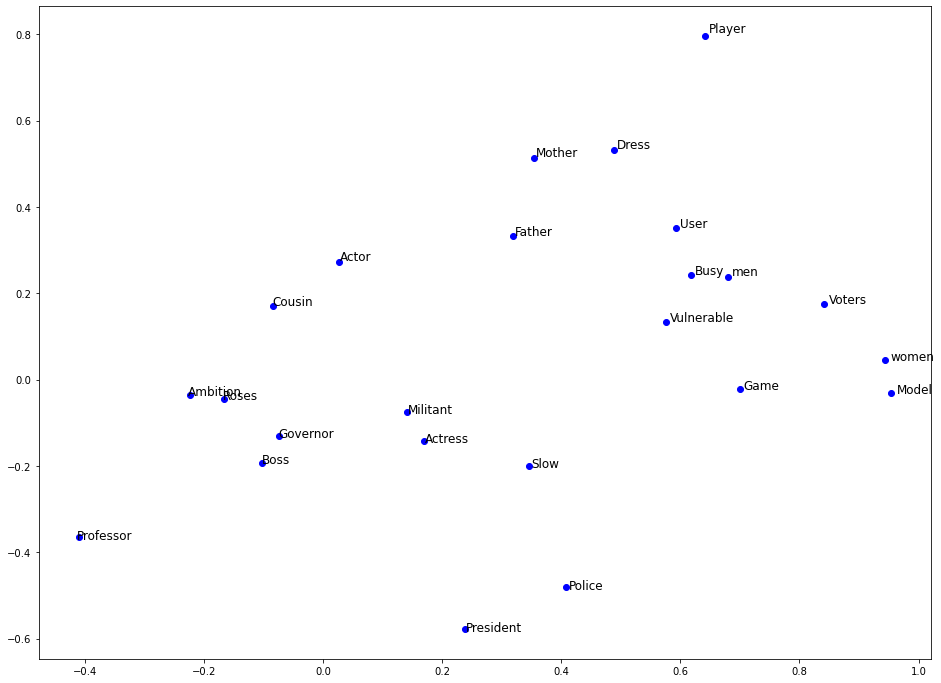

In [26]:
plot_pca(english_model, english_words, english_embeddings)

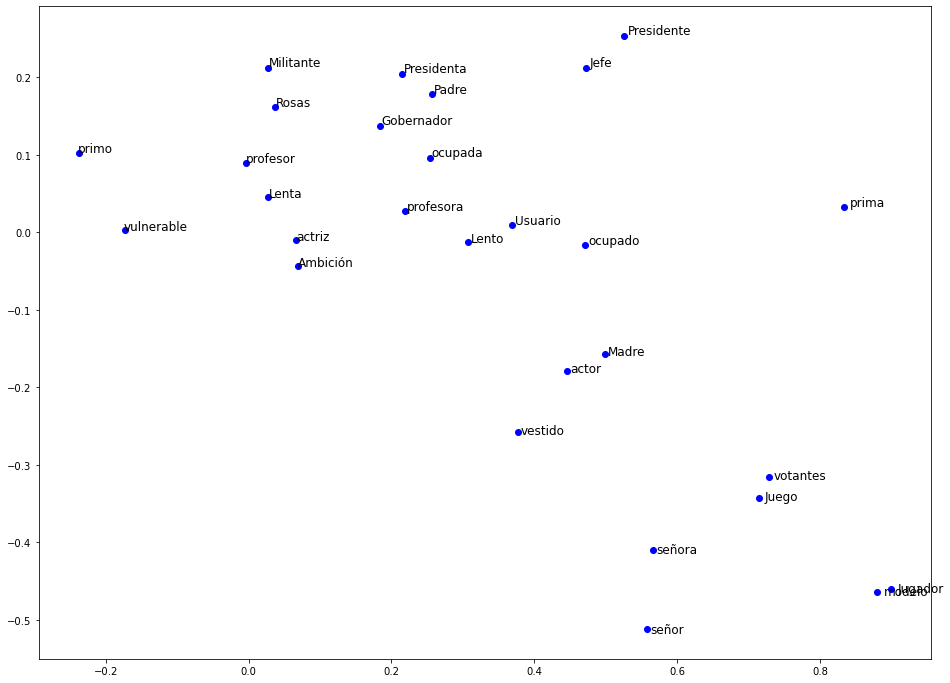

In [27]:
plot_pca(spanish_model, spanish_words, spanish_embeddings)

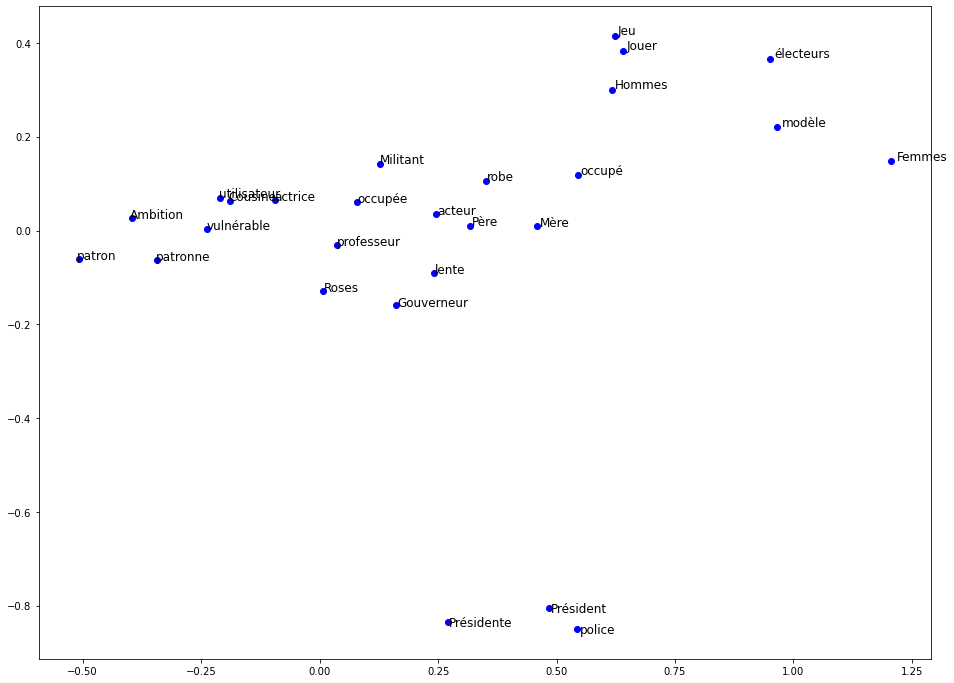

In [28]:
plot_pca(french_model, french_words, french_embeddings)

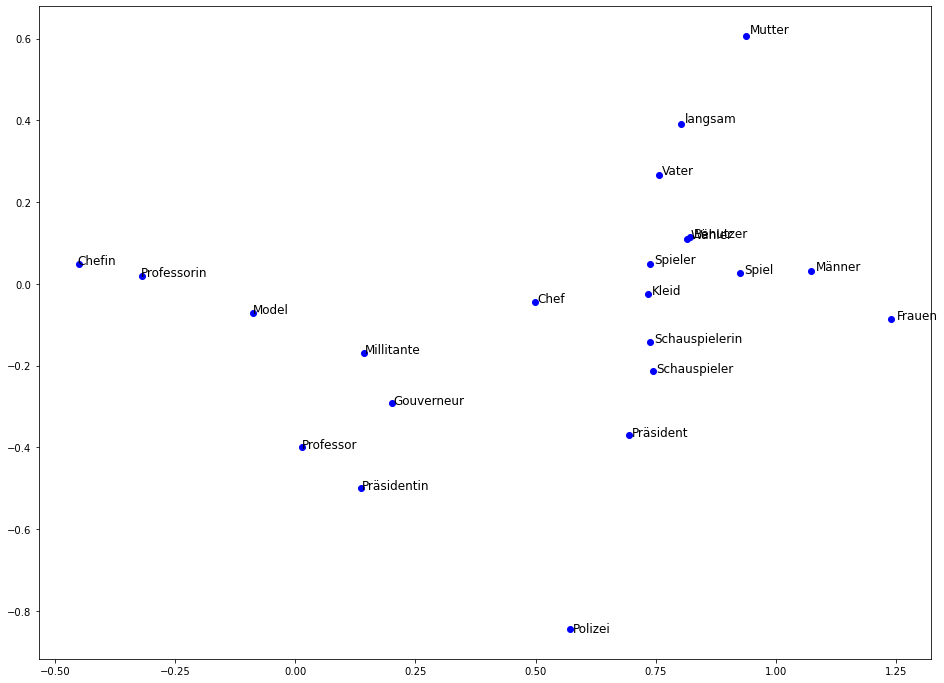

In [29]:
plot_pca(german_model, german_words, german_embeddings)